## Swin transformer - Tutorial
Based on [Link](https://www.geeksforgeeks.org/swin-transformer/) and [link](https://medium.com/thedeephub/building-swin-transformer-from-scratch-using-pytorch-hierarchical-vision-transformer-using-shifted-91cbf6abc678)


Let's start with installing libraries.

In [24]:
!pip install transformers datasets torch torchvision einops matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 30.8 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 37.7 MB/s eta 0:00:00
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)


In [6]:
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np

## Building the model from scratch

![model](https://miro.medium.com/v2/resize:fit:720/format:webp/1*njVvNcQ583BRMEs4jLdzlw.png)

Let's start with patch partition. A Linear mapping is used to convert (H,W,3) => (H/4, W/4, embedding size)

In [7]:
class SwinEmbedding(nn.Module):
    def __init__(self, patch_size=4, emb_size=96):
        super().__init__()
        self.linear_embedding = nn.Conv2d(3, emb_size, kernel_size = patch_size, stride = patch_size)
        self.rearrange = Rearrange('b c h w -> b (h w) c')
        
    def forward(self, x):
        x = self.linear_embedding(x)
        x = self.rearrange(x)
        return x

Then we need to implement patch merging. Which is needed for extracting features at different scales of the input image. Each time, the input size is scaled by a factor of 2 and then passed through a linear layer to get back to 2*embedding_dim.

In [8]:
class PatchMerging(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.linear = nn.Linear(4*emb_size, 2*emb_size)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b (h s1 w s2) c -> b (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W)
        x = self.linear(x)
        return x

Now we need to implement Swin transformer block. We know that we have 2 types of windowing: regular and shifted which are coming one after another. Remember, windowing made quadratic complexity to linear complexity.

To understand the concept of windowing:

![windowing](https://miro.medium.com/v2/resize:fit:720/format:webp/1*fGr3gsejo4p-SoiI24e5YQ.png)

Here we are taking the window size = 4 X 4 in layer 1. Each window will go through a self-attention module as in the traditional ViT. This part is known as Window self-attention. The next part i.e. layer 2 involves shifting the window by (window_size/2, window_size/2) this part is known as Shifted Window Self Attention.

![windowing2](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ENM9cBry4dpZLrzyJRWRpQ.jpeg)

In layer 2 we just shifted the four windows in layer 1 to the right (by window_size(4)/2 = 2) and down (by window_size(4)/2 = 2). Now after the window shift, we are left with some extra dummy space at the right and bottom of the image. Thus we simply replace the extra space with A at the bottom right corner, C at the bottom, and B at the right. This is the main proposed idea of the paper we wanted to somewhat enable communication between the windows or in other words “cross window” attention.

Masking in shifted window MSA:



In [10]:
class ShiftedWindowMSA(nn.Module):
    def __init__(self, emb_size, num_heads, window_size=7, shifted=True):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.window_size = window_size
        self.shifted = shifted
        self.linear1 = nn.Linear(emb_size, 3*emb_size)
    def forward(self, x):
        h_dim = self.emb_size / self.num_heads
        height = width = int(np.sqrt(x.shape[1]))
        x = self.linear1(x)
        
        x = rearrange(x, 'b (h w) (c k) -> b h w c k', h=height, w=width, k=3, c=self.emb_size)
        
        if self.shifted:
            x = torch.roll(x, (-self.window_size//2, -self.window_size//2), dims=(1,2))
        
        x = rearrange(x, 'b (Wh w1) (Ww w2) (e H) k -> b H Wh Ww (w1 w2) e k', w1 = self.window_size, w2 = self.window_size, H = self.num_heads)            
        
        Q, K, V = x.chunk(3, dim=6)
        Q, K, V = Q.squeeze(-1), K.squeeze(-1), V.squeeze(-1)
        wei = (Q @ K.transpose(4,5)) / np.sqrt(h_dim)
        
        if self.shifted:
            row_mask = torch.zeros((self.window_size**2, self.window_size**2)).cuda()
            row_mask[-self.window_size * (self.window_size//2):, 0:-self.window_size * (self.window_size//2)] = float('-inf')
            row_mask[0:-self.window_size * (self.window_size//2), -self.window_size * (self.window_size//2):] = float('-inf')
            column_mask = rearrange(row_mask, '(r w1) (c w2) -> (w1 r) (w2 c)', w1=self.window_size, w2=self.window_size)
            wei[:, :, -1, :] += row_mask
            wei[:, :, :, -1] += column_mask
        
        wei = F.softmax(wei, dim=-1) @ V

Position Embedding:

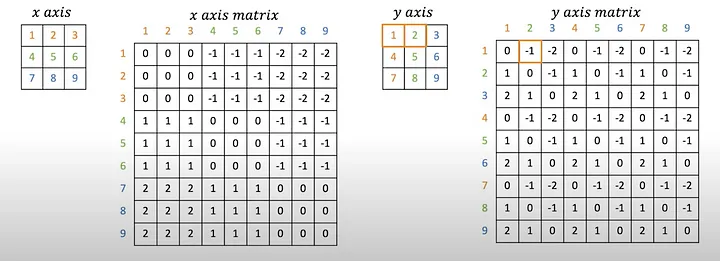

These are the following steps to create relative bias positional embeddings

In the Figure above we are assuming the window size to be 3.
Create an indices matrix along the x-axis and y-axis as shown in the image above.
Here for window size 3, we create a matrix of shape (3² X 3²). We see in the figure above that in the first row in x-axis matrics (1 2 3……9) we have 1 2 3 marked as 0 which is their distance from the first row and 4 5 6 is marked with -1 ( as they are one row below the first row) following the same logic we create the rest of the matrics
The same is done for the y-axis matrix but instead, we do it alone the y-axis. Thus now for the first row in the y-axis, we see 2 is 1 column right of it so we put -1, and then 3 is two columns right of the first row so we put -2 at its place in the y-axis matrix following the same logic we fill the entire matrix.
Finally, we add (M — 1) to every element in both the x and y-axis matrix where M is the window size, in our example 3. We do this to make sure everything is in the range [0, 2M — 1] because, for a window size 3, the relative positions would have to be between [-2, +2]. Then we multiply the x-axis matrix by (2M -1) and add it to the y-axis matrix. The final Relative Position index matrix will have a range of (M² — 1)X(M² — 1) which is (0, 25) here.

![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*wiCWnSMsnanyadQFv8yduw.png)

Here we should be recalling what are we doing and whom are we doing it for. We have a tensor x (shape: B, H, Wh, Ww, win_size², win_size²) and we want to create positional embedding matrics for it, of shape (win_size², win_size²). What we have is a Relative Position Index of shape (M, M) where M is window_size.

In a window size M of 3, we have the position range of (0, 5), and for creating position embedding for matrics shaped (M², M²) we would need the range of (0, 25) as explained in the 5th point.

In the Relative Position Index of shape (M, M) we have 25 (for M=3) unique indices thus it would be better to have the same weight of an Index (say 12) everywhere an index is 12. That is why we pass it to a matrix of shape 5X5 (few implementations use a matrix of shape 5X5 or a linear 25, doesn’t matter and gives the same result) and get the parameters for the Final Positional Embedding.

In [11]:
class ShiftedWindowMSA(nn.Module):
    def __init__(self, emb_size, num_heads, window_size=7, shifted=True):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.window_size = window_size
        self.shifted = shifted
        self.linear1 = nn.Linear(emb_size, 3*emb_size)
        self.linear2 = nn.Linear(emb_size, emb_size)

        self.pos_embeddings = nn.Parameter(torch.randn(window_size*2 - 1, window_size*2 - 1))
        self.indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
        self.relative_indices = self.indices[None, :, :] - self.indices[:, None, :]
        self.relative_indices += self.window_size - 1

    def forward(self, x):
        h_dim = self.emb_size / self.num_heads
        height = width = int(np.sqrt(x.shape[1]))
        x = self.linear1(x)
        
        x = rearrange(x, 'b (h w) (c k) -> b h w c k', h=height, w=width, k=3, c=self.emb_size)
        
        if self.shifted:
            x = torch.roll(x, (-self.window_size//2, -self.window_size//2), dims=(1,2))
        
        x = rearrange(x, 'b (Wh w1) (Ww w2) (e H) k -> b H Wh Ww (w1 w2) e k', w1 = self.window_size, w2 = self.window_size, H = self.num_heads)            
        
        Q, K, V = x.chunk(3, dim=6)
        Q, K, V = Q.squeeze(-1), K.squeeze(-1), V.squeeze(-1)
        wei = (Q @ K.transpose(4,5)) / np.sqrt(h_dim)
        
        rel_pos_embedding = self.pos_embeddings[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        wei += rel_pos_embedding
        
        if self.shifted:
            row_mask = torch.zeros((self.window_size**2, self.window_size**2)).cuda()
            row_mask[-self.window_size * (self.window_size//2):, 0:-self.window_size * (self.window_size//2)] = float('-inf')
            row_mask[0:-self.window_size * (self.window_size//2), -self.window_size * (self.window_size//2):] = float('-inf')
            column_mask = rearrange(row_mask, '(r w1) (c w2) -> (w1 r) (w2 c)', w1=self.window_size, w2=self.window_size)
            wei[:, :, -1, :] += row_mask
            wei[:, :, :, -1] += column_mask
        
        wei = F.softmax(wei, dim=-1) @ V
        
        x = rearrange(wei, 'b H Wh Ww (w1 w2) e -> b (Wh w1) (Ww w2) (H e)', w1 = self.window_size, w2 = self.window_size, H = self.num_heads)
        x = rearrange(x, 'b h w c -> b (h w) c')
        
        return self.linear2(x)

Swin Encoder: Regular window followed by shifted window

In [13]:
class MLP(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.ff = nn.Sequential(
                         nn.Linear(emb_size, 4*emb_size),
                         nn.GELU(),
                         nn.Linear(4*emb_size, emb_size),
                  )
    
    def forward(self, x):
        return self.ff(x)
    
class SwinEncoder(nn.Module):
    def __init__(self, emb_size, num_heads, window_size=7):
        super().__init__()
        self.WMSA = ShiftedWindowMSA(emb_size, num_heads, window_size, shifted=False)
        self.SWMSA = ShiftedWindowMSA(emb_size, num_heads, window_size, shifted=True)
        self.ln = nn.LayerNorm(emb_size)
        self.MLP = MLP(emb_size)
        
    def forward(self, x):
        # Window Attention
        x = x + self.WMSA(self.ln(x))
        x = x + self.MLP(self.ln(x))
        # shifted Window Attention
        x = x + self.SWMSA(self.ln(x))
        x = x + self.MLP(self.ln(x))
        
        return x

Putting it all together.

In [14]:
class Swin(nn.Module):
    def __init__(self):
        super().__init__()
        self.Embedding = SwinEmbedding()
        self.PatchMerging = nn.ModuleList()
        emb_size = 96
        num_class = 5
        for i in range(3):
            self.PatchMerging.append(PatchMerging(emb_size))
            emb_size *= 2
        
        self.stage1 = SwinEncoder(96, 3)
        self.stage2 = SwinEncoder(192, 6)
        self.stage3 = nn.ModuleList([SwinEncoder(384, 12),
                                     SwinEncoder(384, 12),
                                     SwinEncoder(384, 12) 
                                    ])
        self.stage4 = SwinEncoder(768, 24)
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(output_size = 1)
        self.avg_pool_layer = nn.AvgPool1d(kernel_size=49)
        
        self.layer = nn.Linear(768, num_class)

    def forward(self, x):
        x = self.Embedding(x)
        x = self.stage1(x)
        x = self.PatchMerging[0](x)
        x = self.stage2(x)
        x = self.PatchMerging[1](x)
        for stage in self.stage3:
            x = stage(x)
        x = self.PatchMerging[2](x)
        x = self.stage4(x)
        x = self.layer(self.avgpool1d(x.transpose(1, 2)).squeeze(2))
        return x

## Loading pretrained model and evaluation of results

In [35]:
import numpy as np

# Denormalize function
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = tensor.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = image * std + mean  # Reverse normalization
    return np.clip(image, 0, 1)  # Clip values for display

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


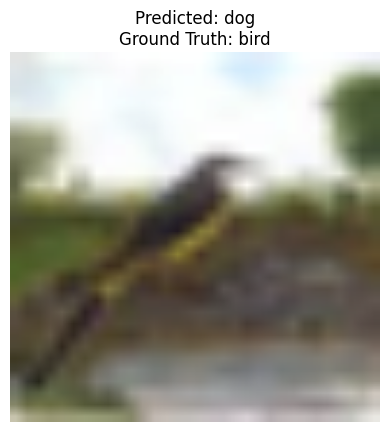

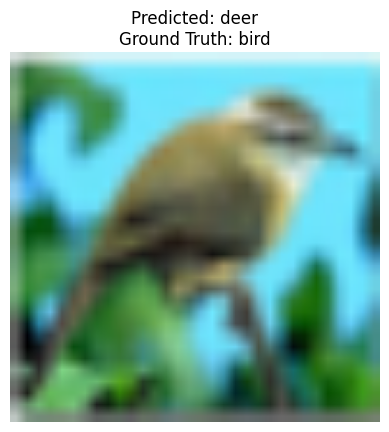

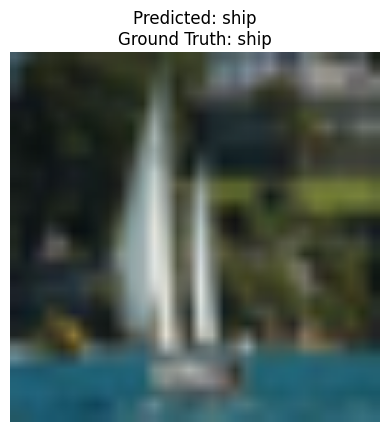

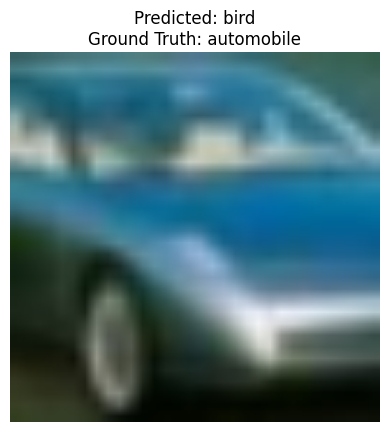

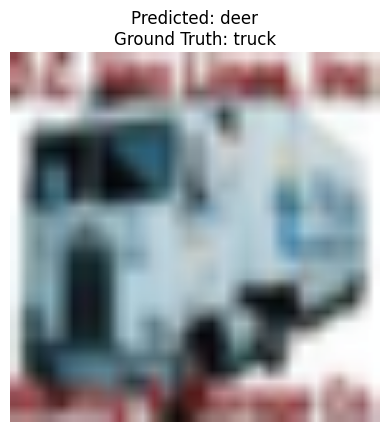

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image
from transformers import SwinForImageClassification, SwinConfig, AutoImageProcessor
import numpy as np

# Load pre-trained Swin Transformer model
model_name = "microsoft/swin-tiny-patch4-window7-224"
feature_extractor = AutoImageProcessor.from_pretrained(model_name)

# ignore_mismatched_sizes=True to allow for image size mismatch. This makes results inaccurate.
model = SwinForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True)
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load CIFAR-10 dataset
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Correct CIFAR-10 class labels
cifar10_labels = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

# Function to denormalize images
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = tensor.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = image * std + mean  # Reverse normalization
    return np.clip(image, 0, 1)  # Clip values for display

def show_image_with_labels(image, predicted_label, true_label):
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}\nGround Truth: {true_label}")
    plt.axis("off")
    plt.show()

# Run inference and display results
for idx, (image, true_label) in enumerate(test_loader):
    if idx >= 5:  # Display 5 sample images
        break
    
    with torch.no_grad():
        outputs = model(image)
        predicted_class = outputs.logits.argmax(dim=-1).item()
        predicted_label = cifar10_labels.get(predicted_class, "Unknown")
        true_label_name = cifar10_labels.get(true_label.item(), "Unknown")
    
    image_np = denormalize(image.squeeze(), feature_extractor.image_mean, feature_extractor.image_std)
    show_image_with_labels(image_np, predicted_label, true_label_name)

Training on CIFAR-10:

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
from transformers import SwinForImageClassification, AutoImageProcessor
import numpy as np

# Load pre-trained Swin Transformer model WITHOUT classifier head
model_name = "microsoft/swin-tiny-patch4-window7-224"
feature_extractor = AutoImageProcessor.from_pretrained(model_name)

model = SwinForImageClassification.from_pretrained(model_name)
model.classifier = nn.Linear(model.config.hidden_size, 10)  # Replace classifier for 10 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match Swin Transformer input size
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# CIFAR-10 class labels
cifar10_labels = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Fine-tune model
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits  # Extract logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save fine-tuned model
torch.save(model.state_dict(), "swin_cifar10.pth")
print("Fine-tuning complete and model saved.")

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")